In [1]:
from onnxruntime.quantization import quantize_dynamic, QuantType
from RT.models.torch_utils import det_postprocess
from RT.models.common import PostDetect, optim
from RT.models.cudart_api import TRTEngine
from RT.models import EngineBuilder
from RT.models.utils import blob
from ultralytics import YOLO
import tensorflow as tf
from io import BytesIO
from PIL import Image
import onnxruntime
import numpy as np
import onnxsim
import torch
import onnx
import os

### Quantization in PyTorch

In [2]:
pt_model = YOLO("best.pt")

In [3]:
pt_model.info()

YOLOv8m summary: 295 layers, 25856899 parameters, 0 gradients


(295, 25856899, 0, 0.0)

In [4]:
pt_model.model.state_dict()

OrderedDict([('model.0.conv.weight',
              tensor([[[[ 2.8259e-02, -1.2317e-01, -6.2866e-02],
                        [ 1.0632e-01, -1.1884e-01,  1.4673e-01],
                        [ 4.8004e-02,  1.3257e-01,  9.1614e-02]],
              
                       [[ 2.7435e-02,  3.7140e-02, -7.8049e-03],
                        [ 1.4050e-01, -4.3823e-02,  4.4518e-03],
                        [ 5.2429e-02,  1.7757e-03, -2.3895e-02]],
              
                       [[ 1.1548e-01, -4.8409e-03, -8.6609e-02],
                        [-7.3242e-02, -3.6987e-02, -4.5197e-02],
                        [-9.6588e-03, -6.0844e-03,  1.1194e-01]]],
              
              
                      [[[-2.8271e-01, -4.5593e-02,  2.1167e-01],
                        [ 2.0642e-01,  6.0059e-01,  5.7080e-01],
                        [-2.8931e-01, -4.9438e-01, -3.1763e-01]],
              
                       [[ 7.5134e-02,  5.9998e-02, -2.1759e-02],
                        [ 2.7734e-01, 

In [5]:
for name, param in pt_model.model.named_parameters():
    print(f"name:{name}\ttype:{param.type()}\tsize:{param.size()}")

name:model.0.conv.weight	type:torch.FloatTensor	size:torch.Size([48, 3, 3, 3])
name:model.0.bn.weight	type:torch.FloatTensor	size:torch.Size([48])
name:model.0.bn.bias	type:torch.FloatTensor	size:torch.Size([48])
name:model.1.conv.weight	type:torch.FloatTensor	size:torch.Size([96, 48, 3, 3])
name:model.1.bn.weight	type:torch.FloatTensor	size:torch.Size([96])
name:model.1.bn.bias	type:torch.FloatTensor	size:torch.Size([96])
name:model.2.cv1.conv.weight	type:torch.FloatTensor	size:torch.Size([96, 96, 1, 1])
name:model.2.cv1.bn.weight	type:torch.FloatTensor	size:torch.Size([96])
name:model.2.cv1.bn.bias	type:torch.FloatTensor	size:torch.Size([96])
name:model.2.cv2.conv.weight	type:torch.FloatTensor	size:torch.Size([96, 192, 1, 1])
name:model.2.cv2.bn.weight	type:torch.FloatTensor	size:torch.Size([96])
name:model.2.cv2.bn.bias	type:torch.FloatTensor	size:torch.Size([96])
name:model.2.m.0.cv1.conv.weight	type:torch.FloatTensor	size:torch.Size([48, 48, 3, 3])
name:model.2.m.0.cv1.bn.weight	t

In [6]:
f"Model size: {round(os.path.getsize('best.pt')/1024/1024,3)} MB"

'Model size: 49.573 MB'

#### 1. Dynamic quantization - weights quantized with activations read/stored in floating point and quantized for compute.

In [7]:
quantized_model = torch.quantization.quantize_dynamic(pt_model.model, {torch.nn.Linear}, dtype=torch.qint8)

#### 2. Static quantization - weights quantized, activations quantized, calibration required post training.

In [ ]:
# set quantization config for server (x86)
deploymentmyModel.qconfig = torch.quantization.get_default_config('fbgemm')

# insert observers
torch.quantization.prepare(pt_model.model, inplace=True)
# Calibrate the model and collect statistics

# convert to quantized version
torch.quantization.convert(pt_model.model, inplace=True)

#### 3. Static quantization aware training - weights quantized, activations quantized, quantization numerics modeled during training

In [ ]:
# specify quantization config for QAT
pt_model.model.qconfig=torch.quantization.get_default_qat_qconfig('fbgemm')

# prepare QAT
torch.quantization.prepare_qat(pt_model.model.state_dict(), inplace=True)

# convert to quantized version, removing dropout, to check for accuracy on each
epochquantized_model=torch.quantization.convert(pt_model.model.eval(), inplace=False)

#### Top-level quantization APIs

In [ ]:
torch.quantization.quantize(model, run_fn, run_args, mapping=None, inplace=False)

In [ ]:
torch.quantization.quantize_dynamic(model, qconfig_spec=None, dtype=torch.qint8, mapping=None, inplace=False)

In [ ]:
torch.quantization.quantize_qat(model, run_fn, run_args, inplace=False)

In [ ]:
torch.quantization.prepare(model, inplace=False, allow_list=None, observer_non_leaf_module_list=None, prehook=None)

In [ ]:
torch.quantization.prepare_qat(model, mapping=None, inplace=False)

In [ ]:
torch.quantization.convert(module, mapping=None, inplace=False, remove_qconfig=True)

#### Test and check model quantization

##### Dynamic quantization

In [8]:
quantized_model = torch.quantization.quantize_dynamic(pt_model.model, {torch.nn.Linear}, dtype=torch.qint8)
quantized_model.state_dict()

OrderedDict([('model.0.conv.weight',
              tensor([[[[ 2.8259e-02, -1.2317e-01, -6.2866e-02],
                        [ 1.0632e-01, -1.1884e-01,  1.4673e-01],
                        [ 4.8004e-02,  1.3257e-01,  9.1614e-02]],
              
                       [[ 2.7435e-02,  3.7140e-02, -7.8049e-03],
                        [ 1.4050e-01, -4.3823e-02,  4.4518e-03],
                        [ 5.2429e-02,  1.7757e-03, -2.3895e-02]],
              
                       [[ 1.1548e-01, -4.8409e-03, -8.6609e-02],
                        [-7.3242e-02, -3.6987e-02, -4.5197e-02],
                        [-9.6588e-03, -6.0844e-03,  1.1194e-01]]],
              
              
                      [[[-2.8271e-01, -4.5593e-02,  2.1167e-01],
                        [ 2.0642e-01,  6.0059e-01,  5.7080e-01],
                        [-2.8931e-01, -4.9438e-01, -3.1763e-01]],
              
                       [[ 7.5134e-02,  5.9998e-02, -2.1759e-02],
                        [ 2.7734e-01, 

In [10]:
torch.save(quantized_model.state_dict(), "best_dynamic_quant_int8.pt")

In [12]:
f"Model size: {round(os.path.getsize('best_dynamic_quant_int8.pt')/1024/1024,3)} MB"

'Model size: 98.92 MB'

##### Static quantization

In [13]:
backend = "qnnpack"
pt_model.model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
quantized_model = torch.quantization.prepare(pt_model.model, inplace=True)
quantized_model = torch.quantization.convert(quantized_model, inplace=True)
quantized_model.state_dict()

OrderedDict([('model.0.conv.weight',
              tensor([[[[ 0.0280, -0.1261, -0.0631],
                        [ 0.1051, -0.1191,  0.1472],
                        [ 0.0491,  0.1332,  0.0911]],
              
                       [[ 0.0280,  0.0350, -0.0070],
                        [ 0.1402, -0.0420,  0.0070],
                        [ 0.0491,  0.0000, -0.0210]],
              
                       [[ 0.1121, -0.0070, -0.0841],
                        [-0.0701, -0.0350, -0.0420],
                        [-0.0070, -0.0070,  0.1121]]],
              
              
                      [[[-0.2803, -0.0491,  0.2102],
                        [ 0.2032,  0.6027,  0.5677],
                        [-0.2873, -0.4976, -0.3154]],
              
                       [[ 0.0771,  0.0631, -0.0210],
                        [ 0.2803,  0.4275, -0.0140],
                        [ 0.1402, -0.4696, -0.7148]],
              
                       [[-0.0350, -0.0070,  0.0420],
                   

In [14]:
torch.save(quantized_model.state_dict(), "best_static_quant_int8.pt")

In [15]:
f"Model size: {round(os.path.getsize('best_static_quant_int8.pt')/1024/1024,3)} MB"

'Model size: 25.22 MB'

### Quantization in ONNX

In [2]:
pt_model = YOLO("best.pt")
success = pt_model.export(format="onnx")

Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Core(TM) i7-9750H 2.60GHz)
YOLOv8m summary (fused): 218 layers, 25840339 parameters, 0 gradients

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

ONNX: starting export with onnx 1.14.0 opset 17...


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 2.3s, saved as 'best.onnx' (98.8 MB)

Export complete (5.9s)
Results saved to /home/foziljon/quantization
Predict:         yolo predict task=detect model=best.onnx imgsz=640 
Validate:        yolo val task=detect model=best.onnx imgsz=640 data=face_detection.yaml 
Visualize:       https://netron.app


In [3]:
onnx_model = onnx.load("best.onnx")

In [4]:
try:
    onnx.checker.check_model(onnx_model)
    
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
    
else:
    print('The model is valid!')

The model is valid!


In [5]:
onnx_model.graph.node

[input: "images"
input: "model.0.conv.weight"
input: "model.0.conv.bias"
output: "/model.0/conv/Conv_output_0"
name: "/model.0/conv/Conv"
op_type: "Conv"
attribute {
  name: "dilations"
  ints: 1
  ints: 1
  type: INTS
}
attribute {
  name: "group"
  i: 1
  type: INT
}
attribute {
  name: "kernel_shape"
  ints: 3
  ints: 3
  type: INTS
}
attribute {
  name: "pads"
  ints: 1
  ints: 1
  ints: 1
  ints: 1
  type: INTS
}
attribute {
  name: "strides"
  ints: 2
  ints: 2
  type: INTS
}
, input: "/model.0/conv/Conv_output_0"
output: "/model.0/act/Sigmoid_output_0"
name: "/model.0/act/Sigmoid"
op_type: "Sigmoid"
, input: "/model.0/conv/Conv_output_0"
input: "/model.0/act/Sigmoid_output_0"
output: "/model.0/act/Mul_output_0"
name: "/model.0/act/Mul"
op_type: "Mul"
, input: "/model.0/act/Mul_output_0"
input: "model.1.conv.weight"
input: "model.1.conv.bias"
output: "/model.1/conv/Conv_output_0"
name: "/model.1/conv/Conv"
op_type: "Conv"
attribute {
  name: "dilations"
  ints: 1
  ints: 1
  type

In [6]:
def show_weights_onnx_model(onnx_model):
    weights = []
    for initializer in onnx_model.graph.initializer:
        weight = onnx.numpy_helper.to_array(initializer)
        weights.append(weight)
    return weights

show_weights_onnx_model(onnx_model)

[array([[[[    0.19985,    -0.87105,    -0.44459],
          [    0.75191,     -0.8404,      1.0377],
          [    0.33948,     0.93752,     0.64789]],
 
         [[    0.19402,     0.26265,   -0.055196],
          [    0.99363,    -0.30992,    0.031483],
          [    0.37078,    0.012558,    -0.16899]],
 
         [[    0.81666,   -0.034234,    -0.61249],
          [   -0.51797,    -0.26157,    -0.31963],
          [  -0.068307,   -0.043029,     0.79162]]],
 
 
        [[[    -2.9639,    -0.47799,      2.2191],
          [     2.1641,      6.2964,      5.9841],
          [     -3.033,      -5.183,     -3.3299]],
 
         [[    0.78769,       0.629,    -0.22812],
          [     2.9076,      4.4689,    -0.16021],
          [      1.482,     -4.9424,     -7.4891]],
 
         [[   -0.38585,   -0.060428,     0.46839],
          [     2.1858,      2.8564,     0.65427],
          [    0.10806,     -1.8364,     -3.3965]]],
 
 
        [[[   -0.27966,      3.6651,     -2.0191],
       

In [7]:
f"Model size: {round(os.path.getsize('best.onnx')/1024/1024,3)} MB"

'Model size: 98.791 MB'

#### Dynamic Quantization

#### Static Quantization

#### Test and check model quantization

In [8]:
quantize_dynamic("best.onnx", "best_quantized_dynamic_int8.onnx", weight_type = QuantType.QInt8)

In [9]:
onnx_quantized_model = onnx.load("best_quantized_dynamic_int8.onnx")

In [10]:
f"Model size: {round(os.path.getsize('best_quantized_dynamic_int8.onnx')/1024/1024,3)} MB"

'Model size: 25.043 MB'

In [11]:
show_weights_onnx_model(onnx_quantized_model)

[array([    -1.5247,       1.269,      0.4982,     0.91373,     -1.6564,      1.6809,     0.91224,    0.016034,     0.57432,     0.80799,      1.0344,      1.2225,      1.2942,      1.0132,     -1.0772,      1.0751,     -1.0849,      1.3986,      1.1364,      1.2533,      1.3354,      1.0014,     -1.6543,   -0.047915,
             1.2779,     0.69325,     -1.2783,    -0.54229,      1.6001,     0.91686,   -0.046898,      1.4085,     0.40792,     0.51959,    -0.83031,     0.81127,     0.82494,     0.29218,     0.91246,     0.96199,      1.3796,     -1.2778,      1.3589,     0.40393,     -1.1606,   -0.028477,     0.62405,    -0.20892],
       dtype=float32),
 array([    0.91389,      1.1407,      1.1543,      1.3422,      1.2298,      1.7197,      1.0027,      1.0521,    -0.35753,      1.0556,     0.74786,     0.42258,     0.43501,      0.9946,     0.84288,      1.9234,     0.93524,       1.381,     0.30522,    -0.67561,     0.17491,      1.2026,      0.1055,     0.61076,
             1.9

### Quantization in TensorRT

In [2]:
import torch

model_name = "best.pt"
input_shape = (1,3,640,640)

b = input_shape[0]
 
Yolo_model = YOLO(model_name)
model = Yolo_model.model.fuse().eval()

device = "cuda:0"

for m in model.modules():
    optim(m)
    m.to(device)
    
model.to(device)

fake_input = torch.randn(input_shape).to(device)
for _ in range(2):
    model(fake_input)

save_path = model_name.replace('.pt', '.onnx')

with BytesIO() as f:
    torch.onnx.export(
        model,
        fake_input,
        f,
        opset_version=11,
        input_names=['images'],
        output_names=['num_dets', 'bboxes', 'scores', 'labels'])
    f.seek(0)
    onnx_model = onnx.load(f)
onnx.checker.check_model(onnx_model)

shapes = [b, 1, b, 100 , 4, b, 100 , b, 100]

for i in onnx_model.graph.output:
    for j in i.type.tensor_type.shape.dim:
        j.dim_param = str(shapes.pop(0))
#if args.sim:
try:
    onnx_model, check = onnxsim.simplify(onnx_model)
    assert check, 'assert check failed'

except Exception as e:
    print(f'Simplifier failure: {e}')

onnx.save(onnx_model, save_path)
print(f'ONNX export success, saved as {save_path}')

YOLOv8m summary (fused): 218 layers, 25840339 parameters, 0 gradients


ONNX export success, saved as best.onnx


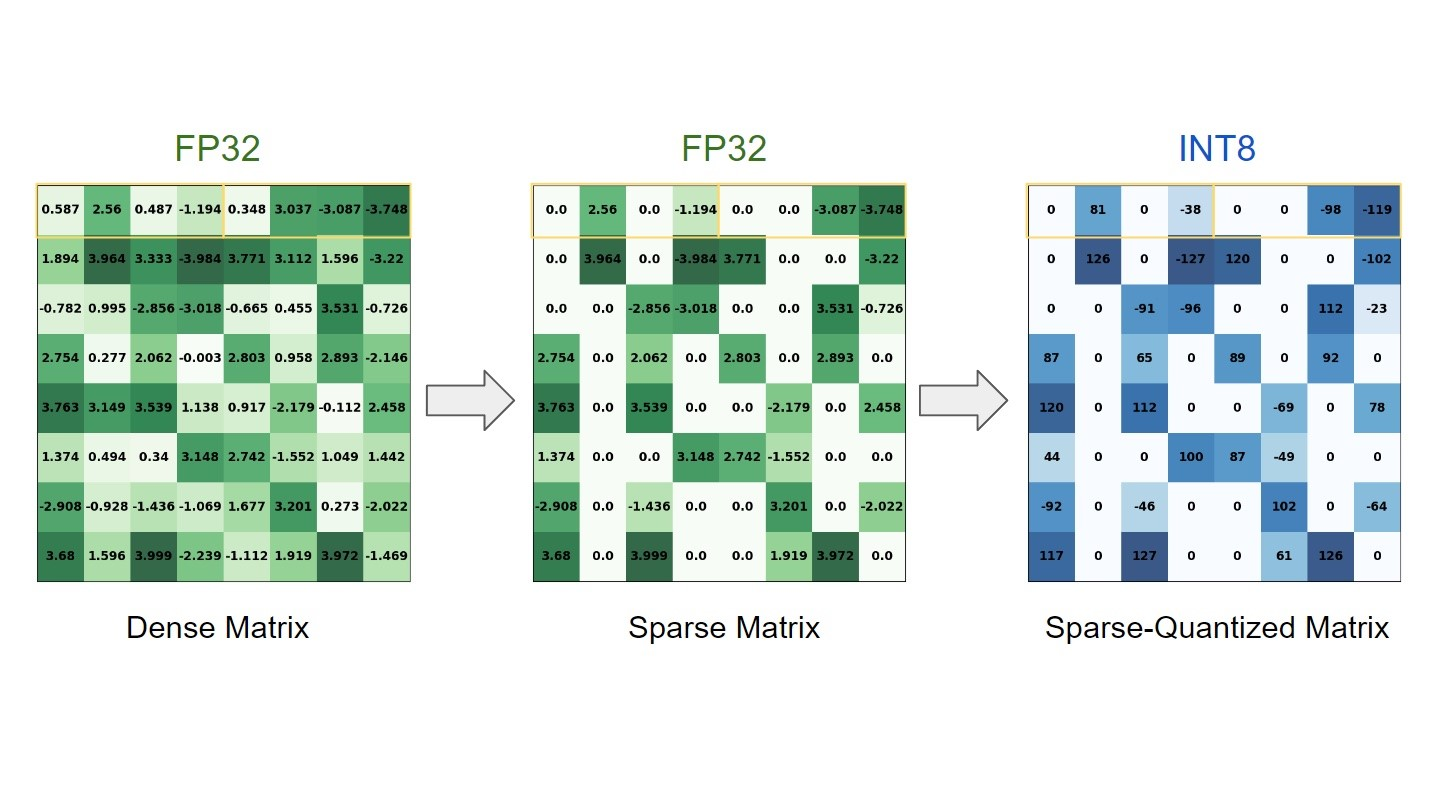

In [3]:
img = Image.open('engine.jpg')
img.show()

#### Test and check model quantization

In [4]:
# FP32 best_engine_fp32.engine
builder_fp32 = EngineBuilder("best.onnx", device)
builder_fp32.seg = True
builder_fp32.build(fp16=False, input_shape=list(input_shape), iou_thres=0.65, conf_thres=0.25, topk=100)

[08/14/2023-16:04:12] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[08/14/2023-16:04:12] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[08/14/2023-16:04:12] [TRT] [W] builtin_op_importers.cpp:5221: Attribute class_agnostic not found in plugin node! Ensure that the plugin creator has a default value defined or the engine may fail to build.
[08/14/2023-16:04:12] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[08/14/2023-16:04:12] [TRT] [W] output "num_dets" with shape: (1, 1) dtype: DataType.INT32
[08/14/2023-16:04:12] [TRT] [W] output "bboxes" with shape: (1, 100, 4) dtype: DataType.FLOAT
[08/14/2023-16:04:12] [TRT] [W] output "scores" with shape: (1, 100) dtype: DataType.FLOAT
[08/14/2023-16:04:12] [TRT] [W] output "labels" with shape: (1, 100) dtype: DataType.INT32
[08/14/2023-16:04:12]

In [5]:
f"Model size: {round(os.path.getsize('best_engine_fp32.engine')/1024/1024,3)} MB"

'Model size: 146.453 MB'

In [6]:
# FP32 best_engine_fp16.engine
builder_fp16 = EngineBuilder("best.onnx", device)
builder_fp16.seg = True
builder_fp16.build(fp16=True, input_shape=list(input_shape), iou_thres=0.65, conf_thres=0.25, topk=100)

[08/14/2023-16:06:38] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[08/14/2023-16:06:38] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[08/14/2023-16:06:38] [TRT] [W] builtin_op_importers.cpp:5221: Attribute class_agnostic not found in plugin node! Ensure that the plugin creator has a default value defined or the engine may fail to build.
[08/14/2023-16:06:38] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[08/14/2023-16:06:38] [TRT] [W] output "num_dets" with shape: (1, 1) dtype: DataType.INT32
[08/14/2023-16:06:38] [TRT] [W] output "bboxes" with shape: (1, 100, 4) dtype: DataType.FLOAT
[08/14/2023-16:06:38] [TRT] [W] output "scores" with shape: (1, 100) dtype: DataType.FLOAT
[08/14/2023-16:06:38] [TRT] [W] output "labels" with shape: (1, 100) dtype: DataType.INT32
[08/14/2023-16:06:38]

In [7]:
f"Model size: {round(os.path.getsize('best_engine_fp16.engine')/1024/1024,3)} MB"

'Model size: 52.86 MB'

In [8]:
# INT8 best_engine_int8.engine
builder_int8 = EngineBuilder("best.onnx", device)
builder_int8.seg = True
builder_int8.int8_mode = True
builder_int8.build(fp16=True, input_shape=list(input_shape), iou_thres=0.65, conf_thres=0.25, topk=100)

[08/14/2023-17:07:48] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[08/14/2023-17:07:48] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[08/14/2023-17:07:48] [TRT] [W] builtin_op_importers.cpp:5221: Attribute class_agnostic not found in plugin node! Ensure that the plugin creator has a default value defined or the engine may fail to build.
[08/14/2023-17:07:48] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[08/14/2023-17:07:48] [TRT] [W] output "num_dets" with shape: (1, 1) dtype: DataType.INT32
[08/14/2023-17:07:48] [TRT] [W] output "bboxes" with shape: (1, 100, 4) dtype: DataType.FLOAT
[08/14/2023-17:07:48] [TRT] [W] output "scores" with shape: (1, 100) dtype: DataType.FLOAT
[08/14/2023-17:07:48] [TRT] [W] output "labels" with shape: (1, 100) dtype: DataType.INT32
[08/14/2023-17:07:48]

In [9]:
f"Model size: {round(os.path.getsize('best_engine_int8.engine')/1024/1024,3)} MB"

'Model size: 52.745 MB'

In [10]:
enggine = TRTEngine('best.engine') #best_engine_fp32.engine

[08/14/2023-18:11:51] [TRT] [W] TensorRT was linked against cuDNN 8.9.0 but loaded cuDNN 8.3.2
[08/14/2023-18:11:51] [TRT] [W] TensorRT was linked against cuDNN 8.9.0 but loaded cuDNN 8.3.2


In [11]:
enggine.inp_info

[Tensor(name='images', dtype=<class 'numpy.float32'>, shape=(1, 3, 640, 640), cpu=array([[[[        nan,         nan,           0, ...,           0,           0,           0],
          [          0,           0,           0, ...,           0,           0,           0],
          [          0,           0,           0, ...,           0,           0,           0],
          ...,
          [          0,           0,           0, ...,           0,           0,           0],
          [          0,           0,           0, ...,           0,           0,           0],
          [          0,           0,           0, ...,           0,           0,           0]],
 
         [[          0,           0,           0, ...,           0,           0,           0],
          [          0,           0,           0, ...,           0,           0,           0],
          [          0,           0,           0, ...,           0,           0,           0],
          ...,
          [          0,        

In [12]:
enggine.out_info

[Tensor(name='num_dets', dtype=<class 'numpy.int32'>, shape=(1, 1), cpu=array([[0]], dtype=int32), gpu=17218338816),
 Tensor(name='bboxes', dtype=<class 'numpy.float32'>, shape=(1, 100, 4), cpu=array([[[          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,           0],
         [          0,           0,           0,   

In [13]:
enggine.weight

PosixPath('best.engine')

### Quantization in TensorFlow and TensorFlow Lite

In [2]:
pt_model = YOLO("best.pt")
success = model.export(format="saved_model")

In [3]:
saved_model_path = "best_saved_model"
tf_model = tf.saved_model.load(saved_model_path)

In [4]:
@tf.function(input_signature=[{"input_1": tf.TensorSpec(shape=[1, 640, 640, 3], dtype=tf.float32)}])

def predict_fn(model_inputs):
   return {"output_1": tf_model(model_inputs["input_1"])}

converter = tf.lite.TFLiteConverter.from_concrete_functions([predict_fn.get_concrete_function()])
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("best_saved_model/best_int8.tflite", "wb") as f:
   f.write(tflite_model)

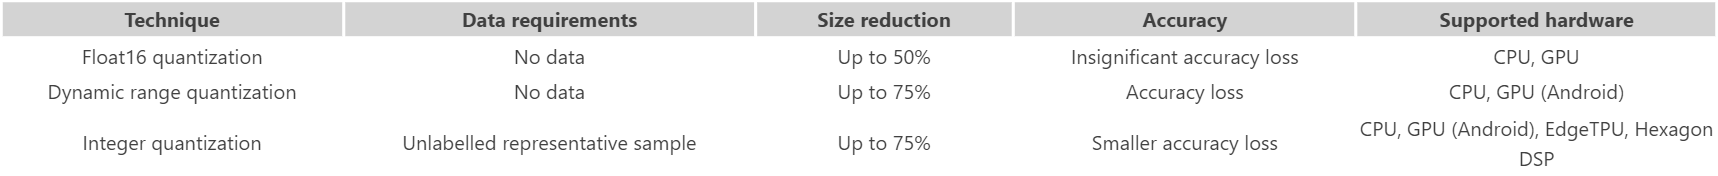

In [5]:
img = Image.open('tflite.png')
img.show()

In [6]:
def get_parameters(model_path):
    tflite_interpreter = tf.lite.Interpreter(model_path = model_path)
    tflite_interpreter.allocate_tensors()
    
    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()
    
    tflite_interpreter.set_tensor(input_details[0]['index'], tflite_interpreter.get_tensor(input_details[0]['index']))
    tflite_interpreter.invoke()
    output_array = tflite_interpreter.get_tensor(output_details[0]['index'])
    
    tensor_details = tflite_interpreter.get_tensor_details()
    
    tensor = tflite_interpreter.tensor
    print("Model parameters:")
    for dict in tensor_details:
        try:
            i = dict['index']
            print(tensor(i)())
            
        except:
            break

#### Test and check model quantization

In [7]:
# tflite FP32
model_path_fp32 = 'best_saved_model/best_float32.tflite'
get_parameters(model_path_fp32)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Model parameters:
[[[[          0           0           0]
   [          0           0           0]
   [          0           0           0]
   ...
   [          0           0           0]
   [          0           0           0]
   [          0           0           0]]

  [[          0           0           0]
   [          0           0           0]
   [          0           0           0]
   ...
   [          0           0           0]
   [          0           0           0]
   [          0           0           0]]

  [[          0           0           0]
   [          0           0           0]
   [          0           0           0]
   ...
   [          0           0           0]
   [          0           0           0]
   [          0           0           0]]

  ...

  [[          0           0           0]
   [          0           0           0]
   [          0           0           0]
   ...
   [          0           0           0]
   [          0           0           0

In [8]:
f"Model size: {round(os.path.getsize(model_path_fp32)/1024/1024,3)} MB"

'Model size: 98.745 MB'

In [9]:
# tflite FP16
model_path_fp16 = 'best_saved_model/best_float16.tflite'
get_parameters(model_path_fp16)

Model parameters:
[[[[    0.57422     0.80811      1.0342]
   [     1.2227      1.2939      1.0137]
   [    -1.0771      1.0752      -1.085]
   ...
   [    0.19385     0.72705     0.49805]
   [    0.95215    -0.18665     0.72363]
   [    0.24817   -0.010155     0.26367]]

  [[     0.6499    -0.17358     0.33154]
   [    0.15674    0.015808    -0.21899]
   [   -0.66016     0.60303    -0.21777]
   ...
   [    0.95557       2.041     0.83057]
   [    -1.2686      2.1836      1.5127]
   [    -1.4717     0.87354     0.89404]]

  [[     1.1338     0.83398      1.7295]
   [     1.5967      0.3501      0.6875]
   [    -1.5352      2.3633      1.9443]
   ...
   [    0.30859     0.24573     0.30957]
   [    0.54541     0.48389    -0.21057]
   [    0.39502     0.84619     0.91504]]

  ...

  [[ -0.0035324   -0.035156   -0.024887]
   [   0.013718   0.0027332   0.0095901]
   [ -0.0050354    0.026505   -0.015976]
   ...
   [  -0.026154    0.002346  -0.0020294]
   [  -0.019272  0.00015807   -0.037872

In [10]:
f"Model size: {round(os.path.getsize(model_path_fp16)/1024/1024,3)} MB"

'Model size: 49.432 MB'

In [11]:
# tflite INT8
model_path_int8 = 'best_saved_model/best_int8.tflite'
get_parameters(model_path_fp32)

Model parameters:
[[[[    0.57422     0.80811      1.0342]
   [     1.2227      1.2939      1.0137]
   [    -1.0771      1.0752      -1.085]
   ...
   [    0.19385     0.72705     0.49805]
   [    0.95215    -0.18665     0.72363]
   [    0.24817   -0.010155     0.26367]]

  [[     0.6499    -0.17358     0.33154]
   [    0.15674    0.015808    -0.21899]
   [   -0.66016     0.60303    -0.21777]
   ...
   [    0.95557       2.041     0.83057]
   [    -1.2686      2.1836      1.5127]
   [    -1.4717     0.87354     0.89404]]

  [[     1.1338     0.83398      1.7295]
   [     1.5967      0.3501      0.6875]
   [    -1.5352      2.3633      1.9443]
   ...
   [    0.30859     0.24573     0.30957]
   [    0.54541     0.48389    -0.21057]
   [    0.39502     0.84619     0.91504]]

  ...

  [[ -0.0035324   -0.035156   -0.024887]
   [   0.013718   0.0027332   0.0095901]
   [ -0.0050354    0.026505   -0.015976]
   ...
   [  -0.026154    0.002346  -0.0020294]
   [  -0.019272  0.00015807   -0.037872

In [12]:
f"Model size: {round(os.path.getsize(model_path_int8)/1024/1024,3)} MB"

'Model size: 25.082 MB'